In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from ladder import ladder_up

In [2]:
def neqr(intensity, x, y, image):
    intensity_bits = len(intensity)
    position_qubits = list(x) + list(y)
    position_bits = len(position_qubits)
    
    qc = QuantumCircuit(intensity, x, y, name="NEQR")

    flat_image = image.flatten()

    for pos in range(2 ** position_bits):
        pixel_intensity = int(flat_image[pos])
        bin_intensity = format(pixel_intensity, f'0{intensity_bits}b')[::-1]
        control_bits = format(pos, f'0{position_bits}b')[::-1]

        control_qubits = []

        for j, cb in enumerate(control_bits):
            q = position_qubits[j]  # Get actual Qubit object
            if cb == '0':
                qc.x(q)
            control_qubits.append(q)

        for i, bit in enumerate(bin_intensity):
            if bit == '1':
                qc.mcx(control_qubits, intensity[i])

        # Uncompute X gates
        for j, cb in enumerate(control_bits):
            if cb == '0':
                qc.x(position_qubits[j])

    return qc.to_gate()


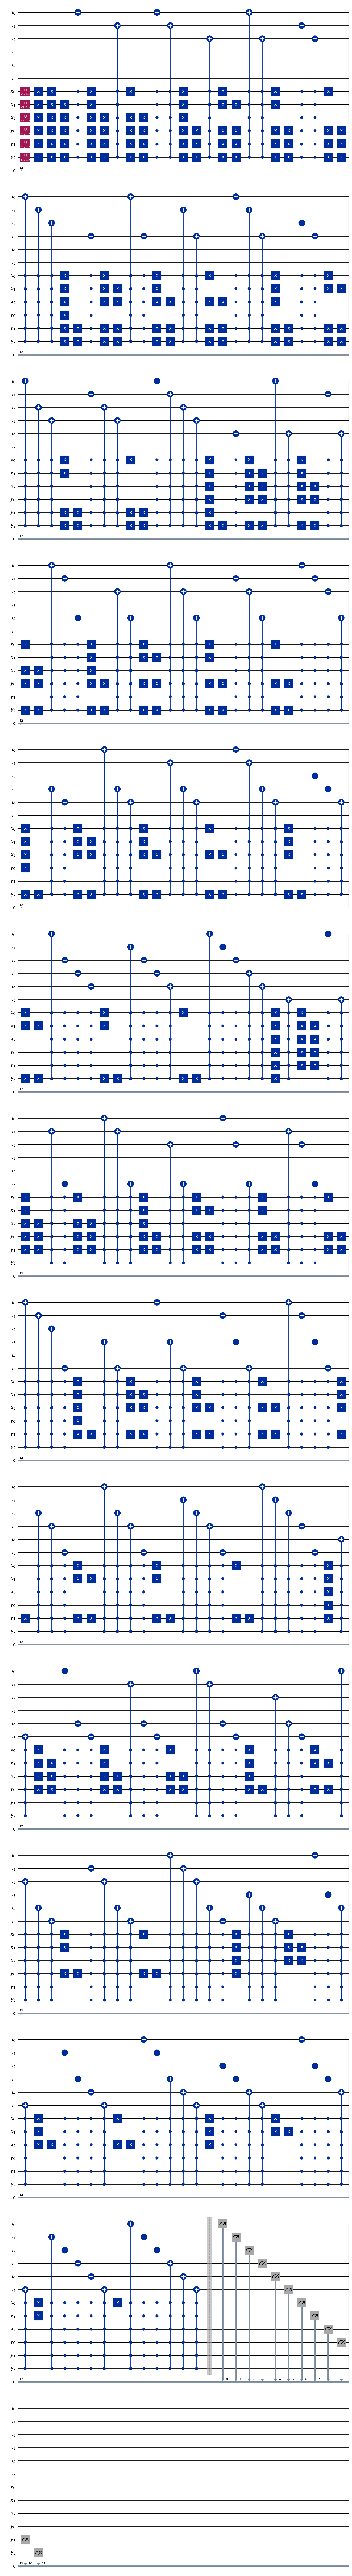

In [3]:
num_bits = 3
x_val = 3
y_val = 7
num_total_qubits = 2 * num_bits + 1
intensity = QuantumRegister(6,name='I')
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
cr = ClassicalRegister(12, name = 'c')
qc = QuantumCircuit(intensity,x,y,cr)
image = np.array([
    [ 0,  1,  2,  3,  4,  5,  6,  7],
    [ 8,  9, 10, 11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20, 21, 22, 23],
    [24, 25, 26, 27, 28, 29, 30, 31],
    [32, 33, 34, 35, 36, 37, 38, 39],
    [40, 41, 42, 43, 44, 45, 46, 47],
    [48, 49, 50, 51, 52, 53, 54, 55],
    [56, 57, 58, 59, 60, 61, 62, 63]
])
qc.h(x)
qc.h(y)
qc.append(neqr(intensity,x,y,image), list(intensity) + list(x) + list(y))
#qc.append(ladder_up(x),list(x))
qc.barrier()
qc.measure(list(intensity) + list(x) + list(y), list(cr))
qc.decompose().draw('mpl')

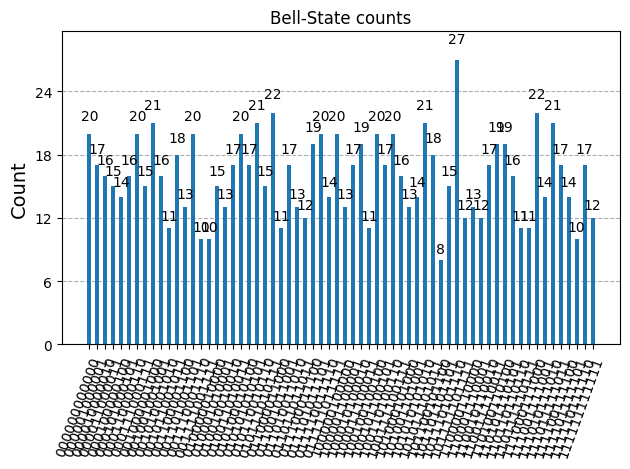

In [4]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [5]:
with open("counts_output.txt", "w") as f:
    for bitstring, count in counts.items():
        f.write(f"{bitstring}: {count}\n")